# EDA on the DROP Dataset

#### Package installs

In [1]:
!pip install --quiet transformers
!pip install --quiet sentencepiece
!pip install --quiet wget
!pip install --quiet datasets
!pip install --quiet ipywidgets
!pip install --quiet tensorflow

#### check gpu

In [2]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


#### Download allennlp drop_eval module

https://github.com/allenai/allennlp-reading-comprehension/blob/master/allennlp_rc/eval/drop_eval.py

In [3]:
!python -m wget https://raw.githubusercontent.com/allenai/allennlp-reading-comprehension/master/allennlp_rc/eval/drop_eval.py

100% [..........................................................] 11222 / 11222
Saved under drop_eval (8).py


#### set directories

In [4]:
!mkdir data

data_dir = "./data"
log_dir = f"{data_dir}/experiments/t5/logs"
save_path = f"{data_dir}/experiments/t5/models"
cache_path_train = f"{data_dir}/cache/t5.train"
cache_path_test = f"{data_dir}/cache/t5.test"

mkdir: data: File exists


#### load packages

In [5]:
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
import tensorflow as tf
import tensorflow.keras as keras
import drop_eval
import pandas as pd
import numpy as np
import json
from datasets import Dataset, load_dataset
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%load_ext tensorboard

#### Define model class

In [14]:
class T5forDrop(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss') 
    
    @tf.function
    def train_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)
            
            grads = tape.gradient(loss, self.trainable_variables)
            
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.optimizer._decayed_lr(tf.float32)
        
        self.loss_tracker.update_state(loss)        
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}
    
    

def annot_barplot(df, x, title,y=None,figsize=(10,7)):
    fig,ax=plt.subplots(figsize=figsize)

    if not y:
        splot = sns.countplot(data=df, x=x)
    else:
        splot = sns.barplot(x=x,y=y)
        plt.xticks(rotation=90)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., 
                        p.get_height()), 
                       ha = 'center', 
                       va = 'center', 
                       xytext = (0, 10), 
                       textcoords = 'offset points')

    _=splot.set_title(title)
    plt.show()

#### Import model and tokenizer

#### Import data

In [7]:
train_dataset = load_dataset('drop', split='train')
valid_dataset = load_dataset('drop', split='validation')

train_dataset.features

Using custom data configuration default
Reusing dataset drop (/Users/omarkapur/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25)
Using custom data configuration default
Reusing dataset drop (/Users/omarkapur/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25)


{'section_id': Value(dtype='string', id=None),
 'query_id': Value(dtype='string', id=None),
 'passage': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'answers_spans': Sequence(feature={'spans': Value(dtype='string', id=None), 'types': Value(dtype='string', id=None)}, length=-1, id=None)}

In [8]:
def eda_encode(example):
    answer = example['answers_spans']['spans']
    answer_type = example['answers_spans']['types']
    outputs = {'answer':answer,'answer_type':answer_type}
    return outputs

Loading cached processed dataset at /Users/omarkapur/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25/cache-459f73ec68d53db7.arrow


unique number of answer types per question:  [1]

Answer type counts:
number    46973
span      29195
date       1232
Name: answer_type, dtype: int64


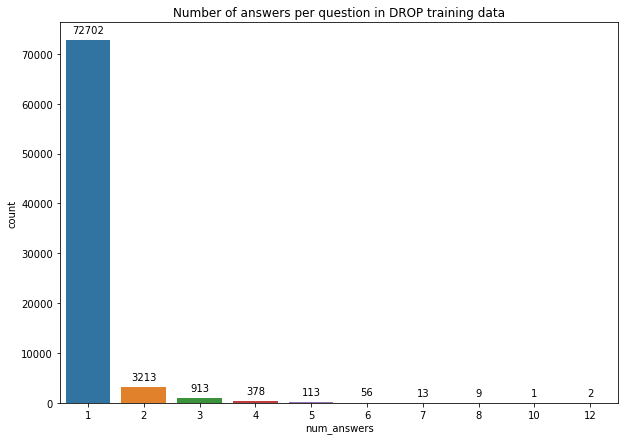

,section_id,query_id,passage,question,answers_spans,answer,answer_type_list,num_answers,answer_type_unique,num_unique_answers,answer_type,question_lower,question_strip
0,nfl_2201,f16c0ee7-f131-4a8b-a6ac-4d275ea68066,"To start the season, the Lions traveled south ...",How many points did the buccaneers need to tie...,"{'spans': ['3'], 'types': ['number']}",[3],[number],1,[number],1,number,how many points did the buccaneers need to tie...,how many points did buccaneers need tie in first?
1,nfl_2201,c9582e03-b01b-42ed-83e0-b90a5334aefa,"To start the season, the Lions traveled south ...",How many field goals did the Lions score?,"{'spans': ['2'], 'types': ['number']}",[2],[number],1,[number],1,number,how many field goals did the lions score?,how many field goals did lions score?
2,nfl_2201,f703d43d-73fa-4fda-8913-d81bd5569700,"To start the season, the Lions traveled south ...",How long was the Lion's longest field goal?,"{'spans': ['28-yard'], 'types': ['span']}",[28-yard],[span],1,[span],1,span,how long was the lion's longest field goal?,how long was lion's longest field goal?
3,nfl_2201,2fd4f473-af2b-44ce-929a-20c82fa6be2c,"To start the season, the Lions traveled south ...",Who caught the touchdown for the fewest yard?,"{'spans': ['Mike Williams'], 'types': ['span']}",[Mike Williams],[span],1,[span],1,span,who caught the touchdown for the fewest yard?,who caught touchdown for fewest yard?
4,nfl_2201,6592e06d-4ad6-484f-a9a5-5cb72c76dfee,"To start the season, the Lions traveled south ...",Who caught the shortest touchdown pass?,"{'spans': ['Calvin Johnson'], 'types': ['span']}",[Calvin Johnson],[span],1,[span],1,span,who caught the shortest touchdown pass?,who caught shortest touchdown pass?


In [9]:
train_df = train_dataset.map(eda_encode)
train_df = train_df.to_pandas()
train_df = train_df.rename(columns={'answer_type':'answer_type_list'})
train_df['num_answers'] = train_df.answer_type_list.str.len()
train_df['answer_type_unique'] = train_df.apply(lambda row: list(set(row['answer_type_list'])),axis=1)
train_df['num_unique_answers'] = train_df.answer_type_unique.str.len()



print('unique number of answer types per question: ', train_df.num_unique_answers.unique())

train_df['answer_type'] = train_df.apply(lambda row: row['answer_type_list'][0],axis=1)

print('\nAnswer type counts:')
print(train_df.answer_type.value_counts())

annot_barplot(train_df, x='num_answers', title='Number of answers per question in DROP training data')

train_df['question_lower'] = train_df.question.str.lower()
#remove stop words (add to list as needed!)
stop_words = ['the','of','to','and']
train_df['question_strip'] = train_df['question_lower'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))


train_df.head()

Analyzing only questions with answers of type "span"

span question vocab size: 174,281


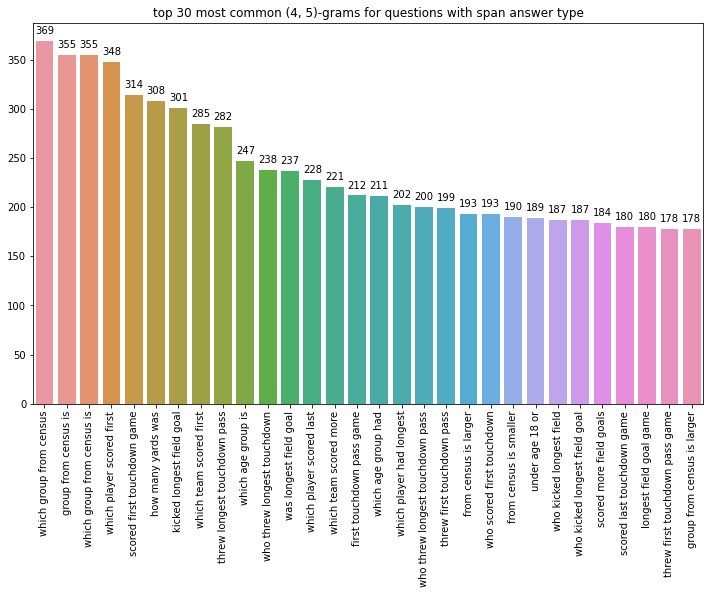




Analyzing only questions with answers of type "number"

number question vocab size: 328,237


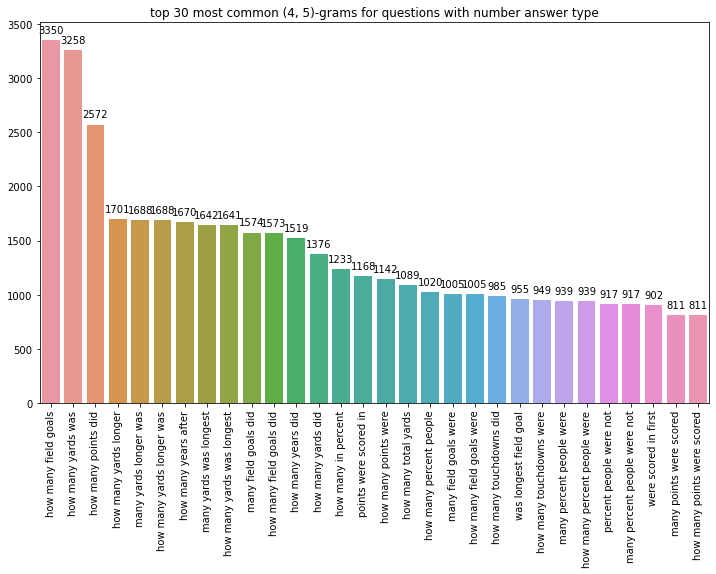




Analyzing only questions with answers of type "date"

date question vocab size: 12,237


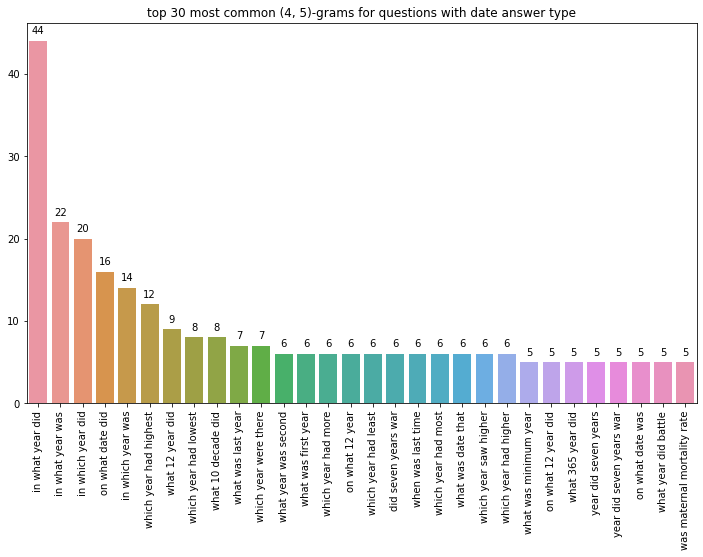

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

def bag_of_words_analysis(df, n=20, ans_type=None, ngram_range=(1,1),make_plot=True,figsize=(10,7)):


    if(ans_type != None):
        df=df[df.answer_type == ans_type]
        print(f'Analyzing only questions with answers of type "{ans_type}"\n')

    vectorizer = CountVectorizer(ngram_range=ngram_range)
    question_wordcount = vectorizer.fit_transform(df.question_strip)

    print('{} question vocab size: {:,}'.format(ans_type,len(vectorizer.get_feature_names())))

    sum_words = question_wordcount.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    if make_plot:
        words = [x[0] for x in words_freq[:n]]
        counts = [x[1] for x in words_freq[:n]]
        annot_barplot(df=None, 
                      x=words, 
                      title='top {} most common {}-grams for questions with {} answer type'.format(n,ngram_range,ans_type),
                      y=counts,
                      figsize=figsize)
    else:
        if ans_type: print(f'top {n} words in questions about {ans_type}s: ')
        else: print(f'top {n} words in all questions')
        print(words_freq[:n])
    print('\n\n')
    
    
ngram_range = (4,5)
figsize=(12,7)
bag_of_words_analysis(train_df,n=30,ans_type = 'span',ngram_range=ngram_range,figsize=figsize)
bag_of_words_analysis(train_df,n=30,ans_type = 'number',ngram_range=ngram_range,figsize=figsize)
bag_of_words_analysis(train_df,n=30,ans_type = 'date',ngram_range=ngram_range,figsize=figsize)
